# SBA Loan: Identifying Predictors of Potential Risk

This notebook follows the structure of the article [*“Should This Loan be Approved or Denied?”*](https://doi.org/10.1080/10691898.2018.1434342) and analyzes SBA loan data to identify key factors associated with loan default.

In [2]:
# IMPORTS
%reload_ext autoreload
%autoreload 2
    
import pandas as pd
import numpy as np

from Utils.prep import Preprocessor as Prep
from Utils.tables import TableBuilder as Table
from Utils.plots import Plotter as Plot

In [3]:
# DESCRIPTION MAPPINGS
# RECESSION
recession_desc = {
    1:'Active',
    0:'Not Active'
}

# STATES
states_desc = {
    'AL':'Alabama', 'AK':'Alaska', 'AZ':'Arizona', 'AR':'Arkansas',
    'CA':'California', 'CO':'Colorado', 'CT':'Connecticut', 'DE':'Delaware',
    'DC': 'District of Columbia', 'FL':'Florida', 'GA':'Georgia', 'HI':'Hawaii',
    'ID':'Idaho', 'IL':'Illinois', 'IN':'Indiana', 'IA':'Iowa', 
    'KS':'Kansas', 'KY':'Kentucky', 'LA':'Louisiana', 'ME':'Maine', 
    'MD':'Maryland', 'MA':'Massachusetts', 'MI':'Michigan', 'MN':'Minnesota',
    'MS':'Mississippi', 'MO':'Missouri', 'MT':'Montana', 'NE':'Nebraska',
    'NV':'Nevada', 'NH':'New Hampshire', 'NJ':'New Jersey', 'NM':'New Mexico',
    'NY':'New York', 'NC':'North Carolina', 'ND':'North Dakota', 'OH':'Ohio',
    'OK':'Oklahoma', 'OR':'Oregon', 'PA':'Pennsylvania', 'RI':'Rhode Island',
    'SC':'South Carolina', 'SD':'South Dakota', 'TN':'Tennessee', 'TX':'Texas',
    'UT':'Utah', 'VT':'Vermont', 'VA':'Virginia', 'WA':'Washington', 'WV':'West Virginia', 
    'WI':'Wisconsin', 'WY':'Wyoming'
}

# NAICS
naics_desc = {
    '11': 'Agriculture, forestry, fishing and hunting',
    '21': 'Mining, quarrying, and oil and gas extraction',
    '22': 'Utilities',
    '23': 'Construction',
    '31': 'Manufacturing',
    '32': 'Manufacturing',
    '33': 'Manufacturing',
    '42': 'Wholesale trade',
    '44': 'Retail trade',
    '45': 'Retail trade',
    '48': 'Transportation and warehousing',
    '49': 'Transportation and warehousing',
    '51': 'Information',
    '52': 'Finance and insurance',
    '53': 'Real estate and rental and leasing',
    '54': 'Professional, scientific, and technical services',
    '55': 'Management of companies and enterprises',
    '56': 'Administrative and support, waste management',
    '61': 'Educational services',
    '62': 'Health care and social assistance',
    '71': 'Arts, entertainment, and recreation',
    '72': 'Accommodation and food services',
    '81': 'Other services (except public administration)',
    '92': 'Public administration'
}

# REALESTATE
realestate_desc = {
    1: 'Backed by Real Estate (Term ≥ 240 months)',
    0: 'Not Backed by Real Estate'
}

# NEWEXIST
newexist_desc = {
    1.0: 'Existing',
    2.0: 'New'
}

In [7]:
# LOAD DATASET
df = pd.read_csv(r'Data\SBAnational.csv', low_memory=False)
print(df.shape)
df.head().T

(899164, 27)


,0,1,2,3,4
LoanNr_ChkDgt,1000014003,1000024006,1000034009,1000044001,1000054004
Name,ABC HOBBYCRAFT,LANDMARK BAR & GRILLE (THE),"WHITLOCK DDS, TODD M.","BIG BUCKS PAWN & JEWELRY, LLC","ANASTASIA CONFECTIONS, INC."
City,EVANSVILLE,NEW PARIS,BLOOMINGTON,BROKEN ARROW,ORLANDO
State,IN,IN,IN,OK,FL
Zip,47711,46526,47401,74012,32801
Bank,FIFTH THIRD BANK,1ST SOURCE BANK,GRANT COUNTY STATE BANK,1ST NATL BK & TR CO OF BROKEN,FLORIDA BUS. DEVEL CORP
BankState,OH,IN,IN,OK,FL
NAICS,451120,722410,621210,0,0
ApprovalDate,28-Feb-97,28-Feb-97,28-Feb-97,28-Feb-97,28-Feb-97
ApprovalFY,1997,1997,1997,1997,1997


### Basic Preparation
- Format `DisbursementDate` as datetime
- Filter loans disbursed through 2010 to ensure outcomes are observable
- Standardize and filter the `MIS_Status` column

In [43]:
# Format date columns 1999-02-28 00:00:00
df = Prep.format_date(df, ['DisbursementDate'])

In [44]:
# Filter disbursed through 2010
df = df[df['DisbursementDate'].dt.year <= 2010]
df.shape

(877025, 27)

In [45]:
# MIS_STATUS
print(df['MIS_Status'].unique())

['P I F' 'CHGOFF' nan]


In [46]:
# Clean and standardize MIS_Staus
df = Prep.unspace(df, ['MIS_Status'])
df = df[df['MIS_Status'].isin(['CHGOFF', 'PIF'])]
print(df['MIS_Status'].unique(), df.shape)

['PIF' 'CHGOFF'] (875250, 27)


### Predictor Analysis
#### Location: `State`
Analyzing default rates by U.S. states to detect geographic patterns.

In [47]:
# Get state default rates
state_defaults = Table.group_by_rate(
    df,
    'State',
    'MIS_Status',
    ['CHGOFF'],
    states_desc
)
# Plot state default rates
fig_state_defaults = Plot.plot_choropleth(
    title='State Shaded by Default Rate of Loans Disbursed before 2011',
    data=state_defaults,
    color_col='CHGOFF',
    locations='State'
)
Table.print_top_bottom(state_defaults, 'State', 'CHGOFF')
fig_state_defaults


Top 5 CHGOFF Rates by State:

MIS_Status State           Description  CHGOFF
50            FL               Florida   27.81
49            GA               Georgia   24.27
48            DC  District of Columbia   24.26
47            NV                Nevada   23.36
46            MI              Michigan   23.14

Bottom 5 CHGOFF Rates by State:

MIS_Status State   Description  CHGOFF
0             MT       Montana    6.93
1             WY       Wyoming    7.10
2             VT       Vermont    7.48
3             ND  North Dakota    7.86
4             SD  South Dakota    7.99


- States like Florida, D.C., and Georgia have the highest loan default rates (>23%), indicating higher credit risk.
- Mountain and Northern Plains states like Montana, Wyoming, and Vermont have the lowest default rates (<8%), showing relatively safer lending environments.


#### Industry: `NAICS`
- Extract the first two digits of the NAICS code to classify loans by broad industry sectors.
- Calculate the default (CHGOFF) rate within each industry group.

In [48]:
# INDUSTRY
# Crearte NAICS2 variable with only first two digits
df['NAICS'] = df['NAICS'].astype(str)
df['NAICS2'] = df['NAICS'].str[:2]

In [49]:
# Calculate defaulr rates by industry
industry_defaults = Table.group_by_rate(df, 'NAICS2', 'MIS_Status', ['CHGOFF'], naics_desc)
industry_defaults

MIS_Status,NAICS2,Description,CHGOFF
0,0,NaN,8.26
1,21,"Mining, quarrying, and oil and gas extraction",8.86
2,11,"Agriculture, forestry, fishing and hunting",9.36
3,55,Management of companies and enterprises,10.44
4,62,Health care and social assistance,10.64
5,33,Manufacturing,13.97
6,22,Utilities,14.71
7,92,Public administration,15.25
8,32,Manufacturing,16.75
9,54,"Professional, scientific, and technical services",19.62


- Real Estate, Finance, and Transportation show the highest default rates (~28–29%), indicating high-risk sectors.
- Mining, Health Care, and Management have the lowest default rates (<11%), suggesting more stable lending.

#### Gross Disbursement: `DisbursementGross`
- Group loans by disbursement quartiles.
- Calculate default rates within each quartile.

In [50]:
# GROSS DISBURSEMENT
print(df['DisbursementGross'].dtype)

object


In [51]:
# Convert values to float and remove signs
df = Prep.unsign(df, ['DisbursementGross'])
print(df['DisbursementGross'].values)
print(df['DisbursementGross'].dtype)

[ 60000.  40000. 287000. ... 300000.  75000.  30000.]
float64


In [52]:
# Calculate loan amount quartiles
dgross_quartiles = Table.quartiles_by_outcomes(df, 'DisbursementGross', 'MIS_Status')
dgross_quartiles

,Quartiles,CHGOFF,PIF
0,100% maximum,"$4,362,157","$11,446,325"
1,75% quartile,"$140,613","$255,000"
2,50% median,"$61,864","$100,000"
3,25% quartile,"$27,746","$49,449"
4,Minimum,"$4,000","$4,000"


- Smaller loans are more likely to default.
- Large loans are often safer: 75% quartile for repaid 255K > defaulted $140K.
- `DisbursementGross` is a strong predictor: Clear difference between distributions for defaulted vs repaid loans.


#### New versus Established Businesses: `NewExist`
Calculating and visualizing default rates by new vs existing businesses.

In [53]:
# NEW OR EXISTING BUSINESSES
print(df['NewExist'].value_counts(dropna=False))
print(df['NewExist'].unique())

NewExist
1.0    627991
2.0    246132
0.0      1024
NaN       103
Name: count, dtype: int64
[ 2.  1.  0. nan]


In [54]:
# Clean and filter NewExist
df = df[df['NewExist'].isin([1, 2])]

MIS_Status,NewExist,Description,CHGOFF
0,0.0,NaN,6.13
1,1.0,Existing,17.11
2,2.0,New,18.75


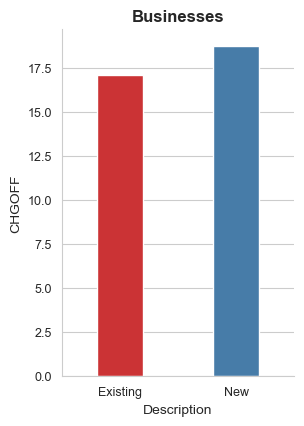

In [11]:
# Calculate and visualize
newexist_defaults = Table.group_by_rate(
    df, 
    'NewExist',
    'MIS_Status',
    ['CHGOFF'],
    newexist_desc
)
fig_newexist_defaults = Plot.plot_barplot(
    'Businesses', 
    newexist_defaults, 
    'Description',
    'CHGOFF'
)
newexist_defaults

- New businesses default slightly more than existing businesses.
- `NewExist` is not a strong predictor.

### Loans Backed by Real Estate: `RealEstate`
- Flag loans with terms ≥ 20 years as real-estate-backed loans.
- Compare default and repayment rates for real-estate-backed vs. other loans.

In [56]:
# LOANS BACKED BY REAL ESTATE
df['RealEstate'] = (df['Term'] >= 240).astype(int)
df['RealEstate'].value_counts()

RealEstate
0    724165
1    149958
Name: count, dtype: int64

In [57]:
# Compare default and repayment rates for real-estate loans vs other loans
realestate_rates = Table.group_by_rate(df, 'RealEstate', 'MIS_Status', ['CHGOFF', 'PIF'], realestate_desc)
realestate_rates

MIS_Status,RealEstate,Description,CHGOFF,PIF
0,1,Backed by Real Estate (Term ≥ 240 months),1.64,98.36
1,0,Not Backed by Real Estate,21.19,78.81


- Real-estate loans are far safer, with 12-13x lower default risk.
- `RealEstate` is a strong predictor.

### Economic Recession: `Recession`
- Create a new binary column **Recession: 1 = Active or 0 = Not Active during the recession**.
- Compare default and repayment rates for both groups.

In [58]:
# RECESSION
recession_start = pd.to_datetime('2007-12-01')
recession_end = pd.to_datetime('2009-06-30')

df['Recession'] = (
    (df['DisbursementDate'] <= recession_end) &
    (
        (df['DisbursementDate'].isna()) | (df['DisbursementDate'] >= recession_start)
    )
).astype(int)

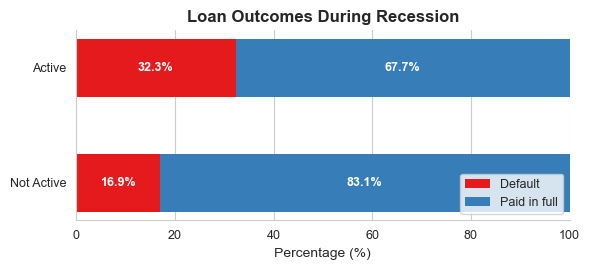

In [59]:
# Calculate and visualize default rates of loans active vs not active during economic recession
recession_rates = Table.group_by_rate(
    df,
    group_by_col='Recession',
    target_col='MIS_Status',
    labels=['CHGOFF', 'PIF'],
    map_data={0: 'Not Active', 1: 'Active'}
)

fig_recession_rates = Plot.plot_binary_split_hbar(
    data=recession_rates,
    label_col='Description',
    positive_col='CHGOFF',
    negative_col='PIF',
    positive_name='Default',
    negative_name='Paid in full',
    title='Loan Outcomes During Recession'
)

In [60]:
#Plot.save_figures({'fig_recession_rates':fig_recession_rates})

- Loans active during the Great Recession have a higher default rate (32.3%) than loans that were not active during the Recession (16.9%).
- `Recession` shows some economic impact and may support other predictors in the model.

#### SBA's Guaranteed Portion of Approved Loan: `Portion`
- Create a dummy variable Portion by calculating SBA_Appv / GrAppv.
- Visualize SBA guarantee portion across loan statuses.

In [61]:
df[['SBA_Appv', 'GrAppv']].dtypes

SBA_Appv    object
GrAppv      object
dtype: object

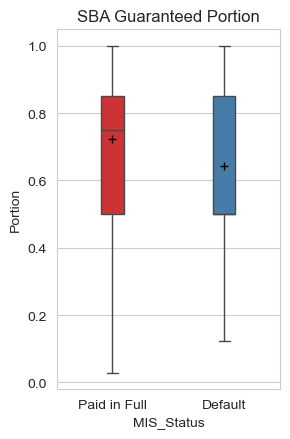

In [12]:
# Remove signs, calculate SBA_Appv / GrAppv, visualize
df = Prep.unsign(df, ['SBA_Appv', 'GrAppv'])
df['Portion'] = df['SBA_Appv'] / df['GrAppv']

fig_portion_rates = Plot.plot_boxplot_by_category(
    data=df,
    x_col='MIS_Status',
    y_col='Portion',
    x_labels=['Paid in Full', 'Default'],
    title='SBA Guaranteed Portion',
    ylabel='Portion'
)

- Defaulted loans tend to have a slightly lower median SBA portion than fully paid loans.
- Both distributions are similar, suggesting SBA coverage has limited direct effect on default rates.
- `Portion` is not a very strong predictor, though it may support other predictors in the model.

In [63]:
print(df.shape)
df.head().T

(874123, 31)


,0,1,2,3,4
LoanNr_ChkDgt,1000014003,1000024006,1000034009,1000044001,1000054004
Name,ABC HOBBYCRAFT,LANDMARK BAR & GRILLE (THE),"WHITLOCK DDS, TODD M.","BIG BUCKS PAWN & JEWELRY, LLC","ANASTASIA CONFECTIONS, INC."
City,EVANSVILLE,NEW PARIS,BLOOMINGTON,BROKEN ARROW,ORLANDO
State,IN,IN,IN,OK,FL
Zip,47711,46526,47401,74012,32801
Bank,FIFTH THIRD BANK,1ST SOURCE BANK,GRANT COUNTY STATE BANK,1ST NATL BK & TR CO OF BROKEN,FLORIDA BUS. DEVEL CORP
BankState,OH,IN,IN,OK,FL
NAICS,451120,722410,621210,0,0
ApprovalDate,28-Feb-97,28-Feb-97,28-Feb-97,28-Feb-97,28-Feb-97
ApprovalFY,1997,1997,1997,1997,1997
